!pip install pydot graphviz


In [2]:
!pip install torchsummary



In [3]:
#!/usr/bin/env pyhton3
# -*- coding 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from torch.utils.data import Dataset, DataLoader

from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import tensorflow as tf
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Introduction to tensorFlow fifa dataset
- multi class
- reLU
- swish


In [6]:
# Global variables
inpDir = './input' # Input Stored here
outDir = './ouput' # output Here
modelDir = './models'# to save Models
subDir = 'fifa_2019' # sub dir by dataset
RANDOM_STATE = 24
np.random.RandomState(seed = RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
#rng = np.random.default_rng(seed = RANDOM_STATE)
#N_SAMPLE = 1000
TEST_SIZE = 3811 # 18147 - 56*256
ALPHA = 0.001 # learning rate
NOISE = 0.2 # Error
EPOCHS = 200
BATCH_SIZE = 256

In [7]:
# inpDir = './input'
# outDir = './output'

In [8]:
#set the plotting parameters
params = {
    'legend.fontsize': 'medium',
    'figure.figsize':(15,4),
    'axes.labelsize':'medium',
    'axes.titlesize':'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize':'medium',
    #'text.usetex':True,
}
plt.rcParams.update(params)
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')


In [9]:
def fn_plot_torch_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset='test_loss')
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid(True)
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()



## Load Data
FIFA DATASET

## EDA
1. Remove Null From Position
2. Read Unique Values from the columns

In [11]:
data_df = pd.read_csv(os.path.join(inpDir,'fifa_2019.csv'))

In [12]:
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [13]:
# X = data_df.drop('Position',axis=1)
# y = data_df['Position']

In [14]:
data_df.dropna(subset= ('Position'), inplace = True)


In [15]:
for col in data_df.columns:
    unq = data_df[col].unique()
    print(f'{col}, #:{len(unq)}, Values:{unq}')

Unnamed: 0, #:18147, Values:[    0     1     2 ... 18204 18205 18206]
ID, #:18147, Values:[158023  20801 190871 ... 241638 246268 246269]
Name, #:17140, Values:['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']
Age, #:29, Values:[31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]
Photo, #:18147, Values:['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']
Nationality, #:164, Values:['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'G

In [16]:
data_df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [17]:
data_df

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,18202,238813,J. Lundstram,19,https://cdn.sofifa.org/players/4/19/238813.png,England,https://cdn.sofifa.org/flags/14.png,47,65,Crewe Alexandra,...,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,€143K
18203,18203,243165,N. Christoffersson,19,https://cdn.sofifa.org/players/4/19/243165.png,Sweden,https://cdn.sofifa.org/flags/46.png,47,63,Trelleborgs FF,...,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,€113K
18204,18204,241638,B. Worman,16,https://cdn.sofifa.org/players/4/19/241638.png,England,https://cdn.sofifa.org/flags/14.png,47,67,Cambridge United,...,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,€165K
18205,18205,246268,D. Walker-Rice,17,https://cdn.sofifa.org/players/4/19/246268.png,England,https://cdn.sofifa.org/flags/14.png,47,66,Tranmere Rovers,...,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,€143K


In [18]:
data_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 18147 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18147 non-null  int64  
 1   ID                        18147 non-null  int64  
 2   Name                      18147 non-null  object 
 3   Age                       18147 non-null  int64  
 4   Photo                     18147 non-null  object 
 5   Nationality               18147 non-null  object 
 6   Flag                      18147 non-null  object 
 7   Overall                   18147 non-null  int64  
 8   Potential                 18147 non-null  int64  
 9   Club                      17918 non-null  object 
 10  Club Logo                 18147 non-null  object 
 11  Value                     18147 non-null  object 
 12  Wage                      18147 non-null  object 
 13  Special                   18147 non-null  int64  
 14  Preferred F

In [19]:
data_df.isnull().sum()

Unnamed: 0           0
ID                   0
Name                 0
Age                  0
Photo                0
                  ... 
GKHandling           0
GKKicking            0
GKPositioning        0
GKReflexes           0
Release Clause    1504
Length: 89, dtype: int64

In [20]:
# num_cols = data_df.select_dtypes(exclude='object')

In [21]:
# num_cols.info()

In [22]:
rel_cols = ['Position', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 
            'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 
            'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 
            'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']


In [23]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [24]:
data_df.dropna(inplace=True)

In [25]:
data_df.isnull().sum().sum()

0

In [26]:
data_df['Position'].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

In [27]:
goalkeeper = 'GK'
forward = ['ST','LW','RW','LF','RF','RS','LS','CF']
midfielder = ['RCM','LCM','LDM','CAM','CDM','RDM','RAM','CM','LAM','RM','LM']
defender = ['CB','RCB','LCB','LWB','RWB','LB','RB']

In [28]:
data_df.loc[data_df['Position'] == 'GK','Position'] = 0
data_df.loc[data_df['Position'].isin(defender),'Position'] = 1
data_df.loc[data_df['Position'].isin(midfielder),'Position'] = 2

data_df.loc[data_df['Position'].isin(forward),'Position'] = 3

In [29]:
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast = 'integer')

In [30]:
data_df['Position'].unique()


array([3, 0, 2, 1], dtype=int8)

In [31]:
class_labels = {0:'Goalkeeper', 1: 'Defender', 2: 'Midfielder', 3: 'Forward'}

In [32]:
X = data_df.drop('Position',axis=1)
y = data_df['Position'].to_numpy()

## Split Data in test train

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,stratify = y, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14336, 33), (3811, 33), (14336,), (3811,))

In [35]:
type(X_train), type(X_test), type(y_train), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 numpy.ndarray,
 numpy.ndarray)

In [36]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [37]:
X_train.shape

(14336, 33)

In [38]:
'''Define custom dataset'''
class FifaDataset(Dataset):
    def __init__(self, X, y):
        super(FifaDataset, self).__init__()
        self.X = torch.tensor(X, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.long)
    def __len__(self): # length of the data = no. of rows 
        return(len(self.X))

    def __getitem__(self, idx): # give me index of X , y
        return self.X[idx], self.y[idx]
    

In [39]:
train_dataset = FifaDataset(X_train, y_train)

In [40]:
train_loader = DataLoader(dataset = train_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle = True
                         )

In [41]:
X_batch , y_batch = next(iter(train_loader))

In [42]:
X_batch.shape, y_batch.shape

(torch.Size([256, 33]), torch.Size([256]))

In [43]:
test_dataset = FifaDataset(X_test, y_test)

In [44]:
test_loader = DataLoader(dataset = test_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle = True
                         )
X_batch, y_batch = next(iter(test_loader))
X_batch.shape, y_batch.shape

(torch.Size([256, 33]), torch.Size([256]))

## comments are alternate ways to do 

* Is environment Ok

In [47]:
# torch.cuda.is_available()

In [48]:
# import torch.version
# torch.version.cuda

In [49]:
# torch.cuda.get_device_name(torch.cuda.current_device())

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [51]:
input_dim = X_train.shape[1]

class Model(nn.Module):
    
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 18)
        self.actv1 = nn.ReLU()
        self.layer2 = nn.Linear(18,4)

    def forward(self, x):
        x = self.layer1(x)
        x = self.actv1(x)
        x = self.layer2(x)
        return x
model = Model(input_dim).to(device=device)
print(model)
# model = nn.Sequential(nn.Linear(input_dim, 18),
#                      nn.ReLU(),
#                      nn.Linear(18,4)
#                      ).to(device=device)


Model(
  (layer1): Linear(in_features=33, out_features=18, bias=True)
  (actv1): ReLU()
  (layer2): Linear(in_features=18, out_features=4, bias=True)
)


In [52]:
summary(model, (1,33))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 18]             612
              ReLU-2                [-1, 1, 18]               0
            Linear-3                 [-1, 1, 4]              76
Total params: 688
Trainable params: 688
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [53]:
for param in list(model.parameters()):
    print(param.shape)

# Input
#Bias


torch.Size([18, 33])
torch.Size([18])
torch.Size([4, 18])
torch.Size([4])


In [54]:
# train_X = torch.tensor(X_train, dtype=torch.float32, device=device)
# train_y = torch.tensor(y_train, dtype=torch.int64, device=device)

# test_X = torch.tensor(X_test, dtype=torch.float32, device=device)
# test_y = torch.tensor(y_test, dtype=torch.int64, device=device)

In [55]:
#torch.optim.RMSprop(model.)

In [56]:

#Loss function
#Compilation and # Fit()
loss_fn = nn.CrossEntropyLoss()
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)
# always need to write 
# some lists to collect progress
loss = []
tloss = []
n_epoch = []
acc = []
tacc=[]

# loop for definedd epochs
for epoch in range(EPOCHS):
    model.train() # set model in training mode 
    epoch_loss = 0
    epoch_acc = 0
    tepoch_loss = 0
    tepoch_acc = 0
   
    for batch_idx, (train_X, train_y) in enumerate(train_loader):
        train_X = train_X.to(device)
        train_y = train_y.to(device)
        predict_proba = model(train_X) # make predict
        batch_loss = loss_fn(predict_proba, train_y) # calculate loss
        epoch_loss += (batch_loss - epoch_loss) / (batch_idx+1) # calculate running mean -> batch loss  for each batch -> then calculate avg loss for epoch
        #curr_loss = loss_fn(predict_proba, train_y)
        # Backpropagation
        optimizer.zero_grad() # Gradient set to Zero
        batch_loss.backward() # calculate loss in backpropagation
        optimizer.step() # move with the steps given by optimizer
        y_pred = predict_proba.argmax(dim=1).cpu().numpy()
        batch_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
        epoch_acc += (batch_acc - epoch_acc)/(batch_idx+1) #accuracy for each batch -> then calculate avg accuracy for epoch
        
    loss.append(epoch_loss.data.item())
    acc.append(epoch_acc)

    model.eval()

    for batch_idx, (test_X, test_y) in enumerate(test_loader):
        test_X, test_y = test_X.to(device), test_y.to(device)
        test_proba = model(test_X)
        batch_loss = loss_fn(test_proba, test_y)
        tepoch_loss += (batch_loss - tepoch_loss)/ (batch_idx + 1)

        y_pred =test_proba.argmax(dim=1).cpu().numpy()
        batch_acc = accuracy_score(test_y.cpu().numpy(), y_pred)
        tepoch_acc += (batch_acc - tepoch_acc)/(batch_idx+1) #accuracy for each batch -> then calculate avg accuracy for epoch
    
    tacc.append(tepoch_acc)
    tloss.append(tepoch_loss.data.item())
    n_epoch.append(epoch)
    # loss.append(curr_loss.data.item())
    # y_pred = torch.argmax(predict_proba, dim=1).cpu().numpy()
    # curr_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
    # acc.append(curr_acc)

    # model.eval()# set your model in eval mode
    # test_proba = model(test_X) # make prediction
    # test_loss = loss_fn(test_proba, test_y) # calculate loss
    # tloss.append(test_loss.data.item()) # append for plotting
    
    # y_pred = torch.argmax(test_proba, dim=1).cpu().numpy()
    # test_acc = accuracy_score(test_y.cpu().numpy(),y_pred)
    # tacc.append(test_acc)
    # n_epoch.append(epoch)

    if epoch % 10 == 0:
        print(f'Epoch:{epoch:>5d} | Loss: {epoch_loss:0.5f}/{tepoch_loss:0.5f}| Accuracy: {epoch_acc:0.5f}/{tepoch_acc:0.5f}')
    
    

Epoch:    0 | Loss: 1.06893/0.83042| Accuracy: 0.62472/0.72304
Epoch:   10 | Loss: 0.32251/0.32673| Accuracy: 0.86935/0.85759
Epoch:   20 | Loss: 0.30054/0.30807| Accuracy: 0.87737/0.86775
Epoch:   30 | Loss: 0.28927/0.30100| Accuracy: 0.88156/0.86996
Epoch:   40 | Loss: 0.28256/0.29655| Accuracy: 0.88539/0.87136
Epoch:   50 | Loss: 0.27809/0.29328| Accuracy: 0.88581/0.87156
Epoch:   60 | Loss: 0.27501/0.29275| Accuracy: 0.88811/0.87101
Epoch:   70 | Loss: 0.27281/0.29217| Accuracy: 0.88888/0.87482
Epoch:   80 | Loss: 0.27099/0.29272| Accuracy: 0.88867/0.87726
Epoch:   90 | Loss: 0.26917/0.29299| Accuracy: 0.88986/0.87589
Epoch:  100 | Loss: 0.26812/0.29323| Accuracy: 0.89111/0.87726
Epoch:  110 | Loss: 0.26735/0.29375| Accuracy: 0.89216/0.87550
Epoch:  120 | Loss: 0.26544/0.29674| Accuracy: 0.89230/0.87800
Epoch:  130 | Loss: 0.26463/0.29540| Accuracy: 0.89209/0.87703
Epoch:  140 | Loss: 0.26368/0.29727| Accuracy: 0.89181/0.87601
Epoch:  150 | Loss: 0.26278/0.29642| Accuracy: 0.89251/

In [57]:
loss_df = pd.DataFrame({'epoch':n_epoch ,
                      'loss':loss,
                        'test_loss':tloss,
                        'acc':acc,
                        'test_acc':tacc
                       }
                        )
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,1.068933,0.830415,0.624721,0.723037
1,1,0.692705,0.580740,0.761440,0.794336
2,2,0.516746,0.468347,0.808105,0.811723
3,3,0.436302,0.417208,0.826172,0.824190
4,4,0.396108,0.388409,0.837193,0.834573


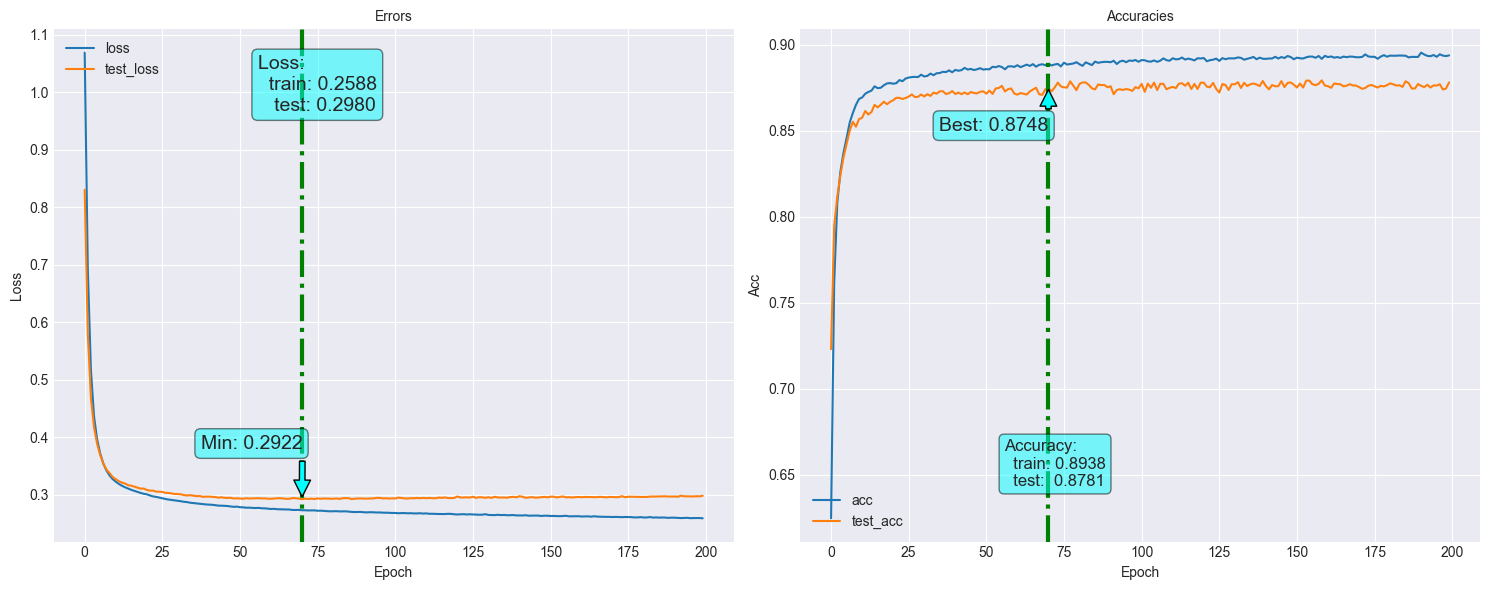

In [58]:
fn_plot_torch_hist(hist_df=loss_df)

## Don't look down

In [59]:
## performance on train data

In [60]:
# outputs = model(train_X)
# outputs.shape

In [61]:
# y_pred = torch.argmax(outputs, dim=1).cpu().numpy() #outputs.cpu().detach().numpy()
# y_pred

In [62]:
# print(classification_report(train_y.cpu().numpy(), y_pred))

In [63]:
# y_true = train_y.cpu().numpy()
# print(classification_report(y_true, y_pred))

In [64]:
# # Confusion Matrix

# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels.values())

# disp.plot(cmap= 'Blues', xticks_rotation = 'vertical', colorbar = False)
# plt.grid(False)

## Don't look down

## Converting  to dataset

* In TensorFlow, Dataset.from_tensor_slices is a method used *
* to create a dataset from a tensor or a list of tensors.*
* It is part of TensorFlow's tf.data API,* 
* which provides tools for building scalable input pipelines.*
*This method allows you to create a dataset from your data (usually stored in tensors or numpy arrays)*
*and slice it into individual elements.*
* These elements can then be fed into a model for training or evaluation.*

In [68]:
# train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))# converting numpy data to tensor dataset

In [69]:
# test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))# converting numpy data to tensor dataset

In [70]:
# type(train_ds),type(X_train)

## Preprocessing And Batching 

In [72]:
# train_ds = train_ds.shuffle(buffer_size  = X_train.shape[0]).batch(BATCH_SIZE) # gives two output X_tensor , y_tensor depends on Batch Size
# test_ds = test_ds.shuffle(buffer_size  = X_test.shape[0]).batch(BATCH_SIZE)

In [73]:
# train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [74]:
# next(iter(train_ds))

*To create a variable with X_train.shape[1] value*

In [76]:
# input_shape = (X_train.shape[1])
# input_shape


* deleting the dataset and freeing the space 

In [78]:
# import gc
# del data_df, X_train, X_test, y_train, y_test
# gc.collect()


In [79]:
# model = tf.keras.Sequential([
#     tf.keras.Input(shape=(X_train.shape[1],), name = 'input'), # input layer
#     tf.keras.layers.Dense(18, activation = 'leaky_relu', name = 'fc_1'), # Hidden layer called dense in tensorflow # tf.nn.silu
#     #tf.keras.layers.Dense(4, activation = 'relu',  name = 'fc_2'),# node called as unit
#     # tf.keras.layers.Dense(4, activation = 'relu', name = 'fc_3'),# fully connected layer(Fc)
#     # tf.keras.layers.Dense(3, activation = 'relu',  name = 'fc_4'),
#     tf.keras.layers.Dense(4, name = 'output')
    
# ])

In [81]:
#model.summary()

In [ ]:
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # y_test, y_pred shape should be equal

In [ ]:
# prediction = model(X_train[:1]).numpy()
# prediction.sum()

In [ ]:
# tf.nn.softmax(prediction).numpy().sum()

In [ ]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
# model.compile(optimizer = optimizer, # optimisation, loss calculation 
#              loss = loss_fn,
#               metrics = ['accuracy']
#              )

# Comments are alternate ways to do 

In [ ]:
# history = model.fit(train_ds,#x = X_train, y = y_train, 
#                     validation_data = test_ds,#[X_test, y_test],
#                     #batch_size = BATCH_SIZE,
#                     verbose = 2,
#                     epochs =EPOCHS
#                    )

In [ ]:
# hist_df = pd.DataFrame(history.history) #Dictionary
# display(hist_df.head())
# fig, axes = plt.subplots(1,2)
# hist_df.plot(y=['loss', 'val_loss'], ax= axes[0])
# hist_df.plot(y=['accuracy', 'val_accuracy'], ax = axes[1])

In [ ]:
# pd.DataFrame(history.history)


## LEAKY ReLU

In [ ]:
# fn_plot_tf_hist(hist_df = hist_df)

In [ ]:
# #PREDICTION MODEL can take Softmax so we won't get any problem becoz during training model behave differently
# # but during validation it behave normally
# prediction_model = tf.keras.Sequential([
#     model,
#     tf.keras.layers.Softmax()
# ])
# prediction_model.summary()

In [ ]:
# # data is coming in batches from train_ds
# y_true, y_pred = [],[]
# for feat, lbls in train_ds: #for count, data in enumerate(train_ds):
#     #feat, lbls = data
#     #print(count,feat.shape, lbls.shape) 
#     pred = prediction_model(feat).numpy() # getting 4 prediction 
#     pred  = pred.argmax(axis=1) # here we get prediction of 1 class/ feature which has highest probability
#     #print(type(pred))
#     y_true.extend(lbls) # Append 
#     y_pred.extend(pred)
# len(y_true), len(y_pred)

In [ ]:
# print(classification_report(y_true,y_pred)) #Support : is the number of actual occurrences of each class in the dataset

In [ ]:
# fn_plot_confusion_matrix(y_true,y_pred,labels=class_labels)

## For test dataset

In [ ]:
# y_true, y_pred = [],[]
# for feat, lbls in test_ds: #for count, data in enumerate(train_ds):
#     #feat, lbls = data
#     #print(count,feat.shape, lbls.shape) 
#     pred = prediction_model(feat).numpy()
#     pred  = pred.argmax(axis=1) # max features index
#     #print(type(pred))
#     y_true.extend(lbls)
#     y_pred.extend(pred)
# len(y_true), len(y_pred)

In [ ]:
# print(classification_report(y_true,y_pred)) #Support : is the number of actual occurrences of each class in the dataset

In [ ]:
# fn_plot_confusion_matrix(y_true,y_pred,labels=class_labels)

In [ ]:
# y_pred = model.predict(X_train)
# accuracy_score(y_true= y_train, y_pred = y_pred.argmax(axis=1))

In [ ]:
# cm = confusion_matrix(y_true=y_train, y_pred= y_pred.argmax(axis=1))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
# fig,ax = plt.subplots(figsize=(4,4))
# disp.plot(ax=ax, cmap= 'Blues', colorbar = False)
# ax.grid(False)

In [ ]:
# y_pred = model.predict(X_test)
# accuracy_score(y_true= y_test, y_pred = y_pred.argmax(axis=1))

In [ ]:
# cm = confusion_matrix(y_true=y_test, y_pred= y_pred.argmax(axis=1))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
# fig,ax = plt.subplots(figsize=(4,4))
# disp.plot(ax=ax, cmap= 'Blues', colorbar = False)
# ax.grid(False)

## DONOT Look Down

In [ ]:
# train.csv -> Train, valid dataset
# accuracy -> predcition on test data


In [ ]:
# model = tf.keras.Sequential([
#     tf.keras.Input(shape=(2,), name = 'input'), # input layer
#     tf.keras.layers.Dense(5, activation = 'relu', name = 'fc_1'), # Hidden layer called dense in tensorflow
#     tf.keras.layers.Dense(5, activation = 'relu',  name = 'fc_2'),# node called as unit
#     tf.keras.layers.Dense(4, activation = 'relu', name = 'fc_3'),# fully connected layer(Fc)
#     tf.keras.layers.Dense(3, activation = 'relu',  name = 'fc_4'),
#     tf.keras.layers.Dense(2, name = 'output')
    
# ])

In [ ]:
 # tf.keras.layers.Dense?


In [ ]:
## Unit testing

In [ ]:
# prediction = model(X_train[:1]).numpy()
# prediction.sum()

In [ ]:
# tf.nn.softmax(prediction).numpy().sum()

In [ ]:
# model.summary()

In [ ]:
# tf.keras.utils.plot_model(model, "My_first_model.png",
#                          show_shapes = True,show_dtype=True,
#                          show_layer_names = True)

In [ ]:
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # y_test, y_pred shape should be equal

In [ ]:
# loss_fn(y_train[:1], prediction).numpy()

In [ ]:
# model.compile(optimizer = 'adam', # optimisation, loss calculation 
#              loss = loss_fn,
#               metrics = ['accuracy']
#              )

In [ ]:
# history = model.fit(x = X_train, y = y_train, 
#                     validation_data = [X_test, y_test],
#                     epochs =EPOCHS
#                    )

In [ ]:
# hist_df = pd.DataFrame(history.history) #Dictionary
# display(hist_df.head())
# fig, axes = plt.subplots(1,2)
# hist_df.plot(y=['loss', 'val_loss'], ax= axes[0])
# hist_df.plot(y=['accuracy', 'val_accuracy'], ax = axes[1])

In [ ]:
# pd.DataFrame(history.history)


In [ ]:
# fn_plot_tf_hist(hist_df = hist_df)

In [ ]:
# y_pred = model.predict(X_train)
# accuracy_score(y_true= y_train, y_pred = y_pred.argmax(axis=1))

In [ ]:
# cm = confusion_matrix(y_true=y_train, y_pred= y_pred.argmax(axis=1))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
# fig,ax = plt.subplots(figsize=(4,4))
# disp.plot(ax=ax, cmap= 'Blues', colorbar = False)
# ax.grid(False)

In [ ]:
# y_pred = predict(model, X_test)
# accuracy_score(y_true = y_test, y_pred = y_pred)


In [ ]:
#1.1**1000

In [ ]:
################### Don't look Down

In [ ]:
# rng = np.random.default_rng(seed=RANDOM_STATE)
# def train_weights(train, alpha, n_epoch):
#     errors = []
#     weights = rng.random(data_train.shape[1]) # randomly generated weights
#     m= train.shape[0] # number of samples
#     for epoch in range(n_epoch):
#         sum_error = 0.0
#         for row in train:
#             prediction = predict(row, weights)
#             dz = prediction - row[-1] # a-y
#             sum_error +=  - row[-1] * np.log(prediction) # sum of squared error
#             weights[0] +=  - alpha * dz / m # calculating and adjusting weights by alpha multiplication and  divide with whole row no. to get error for whole set
#             for i in range(len(row) - 1):
#                 weights[i+1] += -alpha * row[i] * dz / m
#         errors.append(sum_error / m)
#     return errors, weights

In [ ]:
# def predict(model, X_p):
#     W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
#     b1,b2,b3,b4,b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']
#     # Layer1 
#     z1 = X_p.dot(W1) + b1 # Aggregation function
#     a1 = fn_actv(z1) ## Activation function
#     # Layer 2
#     z2 = a1.dot(W2) + b2 # Aggregation function
#     a2 = fn_actv(z2) ## Activation function
#     #Layer 3
#     z3 = a2.dot(W3) + b3 # Aggregation function
#     a3 = fn_actv(z3) ## Activation function
#      #Layer 4
#     z4 = a3.dot(W4) + b4 # Aggregation function
#     a4 = fn_actv(z4) ## Activation function
    
#      #Layer 5
#     z5 = a4.dot(W5) + b5 # Aggregation function
#     a5 = softmax(z5) ## Activation function

#     return a5.argmax(axis=1)


In [ ]:
# def fn_calculate_loss(model, X_l, y_l):
#     W1, W2, W3, W4, W5 = model['W1'], model['W2'], model['W3'], model['W4'], model['W5']
#     b1,b2,b3,b4,b5 = model['b1'], model['b2'], model['b3'], model['b4'], model['b5']

#     m = X_l.shape[0]
    
#     # Layer1 
#     z1 = X_l.dot(W1) + b1 # Aggregation function
#     a1 = fn_actv(z1) ## Activation function
#     # Layer 2
#     z2 = a1.dot(W2) + b2 # Aggregation function
#     a2 = fn_actv(z2) ## Activation function
#     #Layer 3
#     z3 = a2.dot(W3) + b3 # Aggregation function
#     a3 = fn_actv(z3) ## Activation function
#      #Layer 4
#     z4 = a3.dot(W4) + b4 # Aggregation function
#     a4 = fn_actv(z4) ## Activation function
    
#      #Layer 5
#     z5 = a4.dot(W5) + b5 # Aggregation function
#     a5 = softmax(z5) ## Activation function
#     data_loss = -(y_l * np.log(a5) + (1 - y_l)*np.log(1-a5)).sum()
#     return data_loss / m

In [ ]:
# def fn_actv(z):
#     return np.tanh(z)

# def fn_actv_prime(z): # Differentiation of Tanh()
#     return 1 - (np.tanh(z))**2

In [ ]:
# fn_actv(np.array([[-1,0,1],[-np.inf,0,np.inf]]))

In [ ]:
# def predict():
#     z = 1
#     return sigmoid(z) # stepwise Activation Function
        

In [ ]:
# def fn_loss_calculate_loss():
#     pass

## Split DATA in Test Train

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,stratify = y, random_state=RANDOM_STATE)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
# def build_model(param, X_t, y_t, n_epochs= EPOCHS, alpha = ALPHA):
#     '''
#     5-5-4-3
#     '''
#     # get dimensions for weights init
#     m = X_t.shape[0]
    
#     # initialize weights
#     W1 = rng.random((param[0], param[1]), dtype = np.float32) / np.sqrt(param[0])
#     W2 = rng.random((param[1], param[2]), dtype = np.float32)/np.sqrt(param[1])
#     W3 = rng.random((param[2], param[3]), dtype = np.float32)/np.sqrt(param[2]) 
#     W4 = rng.random((param[3], param[4]), dtype = np.float32)/np.sqrt(param[3])
#     W5 = rng.random((param[4], param[5]), dtype = np.float32)/np.sqrt(param[4])
    
#     # initialize bias
#     b1 = np.zeros((1,param[1]), dtype = np.float32)
#     b2 = np.zeros((1,param[2]), dtype = np.float32)
#     b3 = np.zeros((1,param[3]), dtype = np.float32)
#     b4 = np.zeros((1,param[4]), dtype = np.float32)
#     b5 = np.zeros((1,param[5]), dtype = np.float32)

#     # print(W1.shape, W2.shape, W3.shape, W4.shape, W5.shape)
#     # print(b1.shape, b2.shape, b3.shape, b4.shape, b5.shape)
    
#     curr_loss = 0
#     loss = []
#     # loss_hist = {}
#     epoch = []
#     for i in range(n_epochs):
#         ### Forwards propagation
#         # Layer1 
#         z1 = X_t.dot(W1) + b1 # Aggregation function
#         a1 = fn_actv(z1) ## Activation function
#         # Layer 2
#         z2 = a1.dot(W2) + b2 # Aggregation function
#         a2 = fn_actv(z2) ## Activation function
#     #Layer 3
#         z3 = a2.dot(W3) + b3 # Aggregation function
#         a3 = fn_actv(z3) ## Activation function
#          #Layer 4
#         z4 = a3.dot(W4) + b4 # Aggregation function
#         a4 = fn_actv(z4) ## Activation function

#          #Layer 5
#         z5 = a4.dot(W5) + b5 # Aggregation function
#         a5 = softmax(z5) ## Activation function

#     # # Layer2
#     #     z2 = a1.dot(W2) + b2 # Aggregation function
#     #     a2 = sigmoid(z2)# Activation function

#         ### Back Propagation
#         ## Layer 5
#         dz5 = a5 - y_t # y should be of shape (1,m)
        
#         dW5 = (a4.T).dot(dz5)
#         assert(W5.shape == dW5.shape), f'Shape: W5- {W5.shape} and dW5-{dW5.shape}'
#         db5 = np.sum(dz5, axis = 0, keepdims =True)
#         assert(b5.shape == db5.shape), f'Shape: b5- {b5.shape} and db5-{db5.shape}'
#         da4 = dz5.dot(W5.T)
#         assert(a4.shape == da4.shape), f'Shape: a4-{a4.shape} and da4-{da4.shape}'
#         # layer 4
#         dz4 = da4 * fn_actv_prime(z4)
#         dW4 = (a3.T).dot(dz4)
#         assert(W4.shape == dW4.shape),f'Shape: W4- {W4.shape} and dW4-{dW4.shape}'
#         db4 = np.sum(dz4, axis = 0, keepdims =True)
#         assert(b4.shape == db4.shape), f'Shape: b4- {b4.shape} and db4-{db4.shape}'
#         da3 = dz4.dot(W4.T)
#         assert(a3.shape == da3.shape), f'Shape: a3-{a3.shape} and da3-{da3.shape}'

#         # layer3
#         dz3 = da3 * fn_actv_prime(z3)
#         dW3 = (a2.T).dot(dz3)
#         assert(W3.shape == dW3.shape),f'Shape: W3- {W3.shape} and dW3-{dW3.shape}'
#         db3 = np.sum(dz3, axis = 0, keepdims =True)
#         assert(b3.shape == db3.shape), f'Shape: b3- {b3.shape} and db3-{db3.shape}'
#         da2 = dz3.dot(W3.T)
#         assert(a2.shape == da2.shape), f'Shape: a2-{a2.shape} and da2-{da2.shape}'

#         #Layer2
#         dz2 = da2 * fn_actv_prime(z2)
#         dW2 = (a1.T).dot(dz2)
#         assert(W2.shape == dW2.shape), f'Shape: W2- {W2.shape} and dW2-{dW2.shape}'
#         db2 = np.sum(dz2, axis = 0, keepdims =True)
#         assert(b2.shape == db2.shape), f'Shape: b2- {b2.shape} and db2-{db2.shape}'
#         da1 = dz2.dot(W2.T)    
#         assert(a1.shape == da1.shape), f'Shape: a1-{a1.shape} and da1-{da1.shape}'

#         #layer1
#         dz1 = da1 *fn_actv_prime(z1)
#         assert(z1.shape == dz1.shape),f'Shape: z1-{z1.shape} and dz1-{dz1.shape}'
#         dW1 = (X_t.T).dot(dz1)
#         assert(W1.shape == dW1.shape), f'Shape: W1-{W1.shape} and dW1-{dW1.shape}'
#         db1 = np.sum(dz1, axis = 0, keepdims = True)
#         assert(b1.shape == db1.shape), f'Shape: b1-{b1.shape} and db1-{db1.shape}' # assert kind of exception handling
#                 # if shape don't match it fire error, if true do nothing


        
        


        
        
        
        

#         ## Gradient Update
#         W1 += -alpha *dW1 /m
#         W2 += -alpha *dW2 /m
#         W3 += -alpha *dW3 /m
#         W4 += -alpha *dW4 /m
#         W5 += -alpha *dW5 /m
#         b1 += -alpha *db1 /m
#         b2 += -alpha *db2 /m
#         b3 += -alpha *db3 /m
#         b4 += -alpha *db4 /m
#         b5 += -alpha *db5 /m

#         model = {'W1': W1,'W2':W2,'W3':W3, 'W4':W4, 'W5': W5,
#                 'b1': b1, 'b2':b2, 'b3':b3, 'b4':b4, 'b5':b5                
#                 }
        
#         if i%100==0:
#             curr_loss = fn_calculate_loss(model, X_t, y_t)
#             loss.append(curr_loss)
#             epoch.append(i)
            
#         if i%1000 == 0:
#            print(f'Loss after {i:>5d} epochs : {curr_loss:0.5f}')

#     # printing the error reduction curve
#     loss_hist['epoch'] = epoch
#     loss_hist['loss'] = loss
#     fig, ax = plt.subplots()
#     ax.plot(loss)
    
    
#     return model
    

In [ ]:
# loss_hist = {}
# layer_params = [X_train.shape[1], 50,50,40,30,y_train.shape[1]]#[2,5,5,4,3,2]
# #y_train = y_train.reshape(-1,1)
# #y_train.shape

In [ ]:
# y_train = y_train.reshape(-1,1)
# y_train.shape

In [ ]:
# loss_hist = {}


In [ ]:
# model = build_model(layer_params,X_train,y_train )

In [ ]:
# pd.DataFrame(loss_hist).plot(x='epoch', y='loss');

In [ ]:
# y_pred = predict(model, X_train)
# accuracy_score(y_true = y_train.argmax(axis=1), y_pred = y_pred)


In [ ]:
# cm = confusion_matrix(y_true=y_train.argmax(axis=1), y_pred= y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
# fig,ax = plt.subplots(figsize=(4,4))
# disp.plot(ax=ax, cmap= 'Blues', colorbar = False)
# ax.grid(False)

In [ ]:
# y_pred = predict(model, X_test)
# accuracy_score(y_true = y_test.argmax(axis=1), y_pred = y_pred)


In [ ]:
# cm = confusion_matrix(y_true=y_test.argmax(axis=1), y_pred= y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
# fig,ax = plt.subplots(figsize=(4,4))
# disp.plot(ax=ax, cmap= 'Blues', colorbar = False)
# ax.grid(False)

In [ ]:
# def fn_plot_decision_boundary(model, X_tr, y_tr, X_ts, y_ts):
#     fig, ax = plt.subplots(figsize =(8,5))
#     dm = 0.05
#     # Min and Max Along Two Axis 
#     x_min, x_max = X_tr[:,0].min(), X_tr[:,0].max()
#     y_min, y_max = X_tr[:,1].min(), X_tr[:,1].max()

#     display(x_min, x_max)
#     display(y_min, y_max)

#     ## generate a mesh grid
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, dm), 
#                     np.arange(y_min, y_max, dm))
#     display(xx.shape,yy.shape)
#     # ravel means 2d -> 1d
    
#     XX = np.c_[xx.ravel(), yy.ravel()]
#     display(XX.shape)
    
#     y_pred = predict(model,XX)
#     display(y_pred.shape)
#     Z = np.array(y_pred).reshape(xx.shape)
#     ax.contourf(xx, yy, Z, alpha = 0.8 , cmap = plt.cm.Paired)
#     ax.scatter(X_tr[:,0], X_tr[:,1], c = y_tr.argmax(axis=1), edgecolors = 'k', cmap=CMAP)
#     ax.scatter(X_ts[:,0], X_ts[:,1], c = y_ts.argmax(axis=1), edgecolors = 'k', cmap=CMAP, marker ='*')


In [ ]:
# fn_plot_decision_boundary(model, X_train, y_train, X_test, y_test)